# Vlasov-Poisson 

In this notebook we present a multithreaded version of the Vlasov-Poisson system in 1D1D phase space.
Equations are solved numerically using semi-lagrangian method. The serial version of this code,optimized 
succesively by f2py, numba, pythran and cython is available on Github http://github.com/pnavaro/python-notebooks

I made some tests with multiprocessing library from python but it is not very effective.

The first version i propose is to translate the advection functions in fortran.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (11,7)

In [3]:
%load_ext fortranmagic
%env CC='gcc-7'
%env FC='gfortran'

env: CC='gcc-7'
env: FC='gfortran'


In [4]:
%%fortran --link fftw3 --f90flags "-O3 -march=native -fopenmp" --extra "-L/usr/local/lib -lgomp"

module bsl_fftw

   use, intrinsic :: iso_c_binding
   implicit none
   include 'fftw3.f03'
   
   contains
   
   recursive function bspline(p, j, x) result(res)
   
      integer :: p, j
      real(8) :: x, w, w1
      real(8) :: res
   
      if (p == 0) then
          if (j == 0) then
              res = 1.0
              return
          else
              res = 0.0
              return
          end if
      else
          w = (x - j) / p
          w1 = (x - j - 1) / p
      end if
   
      res = w * bspline(p-1,j,x)+(1-w1)*bspline(p-1,j+1,x)
   
   end function bspline
   
   subroutine advection(p, n, deltax, alpha, df)
   
      integer, intent(in)     :: p
      integer, intent(in)     :: n
      real(8), intent(in)     :: deltax
      real(8), intent(inout)  :: df(0:n-1,0:n-1)
      !f2py optional , depend(in) :: n=len(f)
      real(8), intent(in)     :: alpha(0:n-1)
   
      real(8),    allocatable :: f(:)
      complex(8), allocatable :: ft(:)
      real(8),    allocatable :: eig_bspl(:)
      real(8),    allocatable :: modes(:)
      complex(8), allocatable :: eigalpha(:)
      integer(8)              :: fwd
      integer(8)              :: bwd
   
      integer                 :: i
      integer                 :: j
      integer                 :: ishift
      real(8)                 :: beta
      real(8), parameter      :: pi = 3.141592654
   
      allocate(modes(0:n/2))
      allocate(eigalpha(0:n/2))
      allocate(eig_bspl(0:n/2))
      allocate(f(0:n-1))
      allocate(ft(0:n/2))
   
      do i = 0, n/2
         modes(i) = 2 * pi * i / n
      end do
    
      call dfftw_plan_dft_r2c_1d(fwd, n, f, ft, FFTW_ESTIMATE)
      call dfftw_plan_dft_c2r_1d(bwd, n, ft, f, FFTW_ESTIMATE)
   
      eig_bspl = 0.0   
      do j = 1, (p+1)/2
         eig_bspl = eig_bspl + bspline(p, j-(p+1)/2, 0.0_8) * 2.0 * cos(j * modes)
      end do
   
      eig_bspl = eig_bspl + bspline(p, -(p + 1) / 2, 0.0_8)
    
      !$OMP PARALLEL DO DEFAULT(FIRSTPRIVATE), SHARED(df,fwd,bwd)
      do i = 1, n
   
         ishift = floor(-alpha(i) / deltax)
         beta   = -ishift - alpha(i) / deltax
         eigalpha = (0.0, 0.0)
       
         do j=-(p-1)/2, (p+1)/2+1
            eigalpha = eigalpha + bspline(p, j-(p+1)/2, beta) * exp((ishift+j) * (0.0,1.0) * modes)
         end do     
      
         f = df(:,i)
         call dfftw_execute_dft_r2c(fwd, f, ft)
         ft = ft * eigalpha / eig_bspl / n
         call dfftw_execute_dft_c2r(bwd, ft, f)
         df(:,i) = f
        
      end do
      !$OMP END PARALLEL DO     
      
      call dfftw_destroy_plan(fwd)
      call dfftw_destroy_plan(bwd)
   
   end subroutine advection


end module bsl_fftw

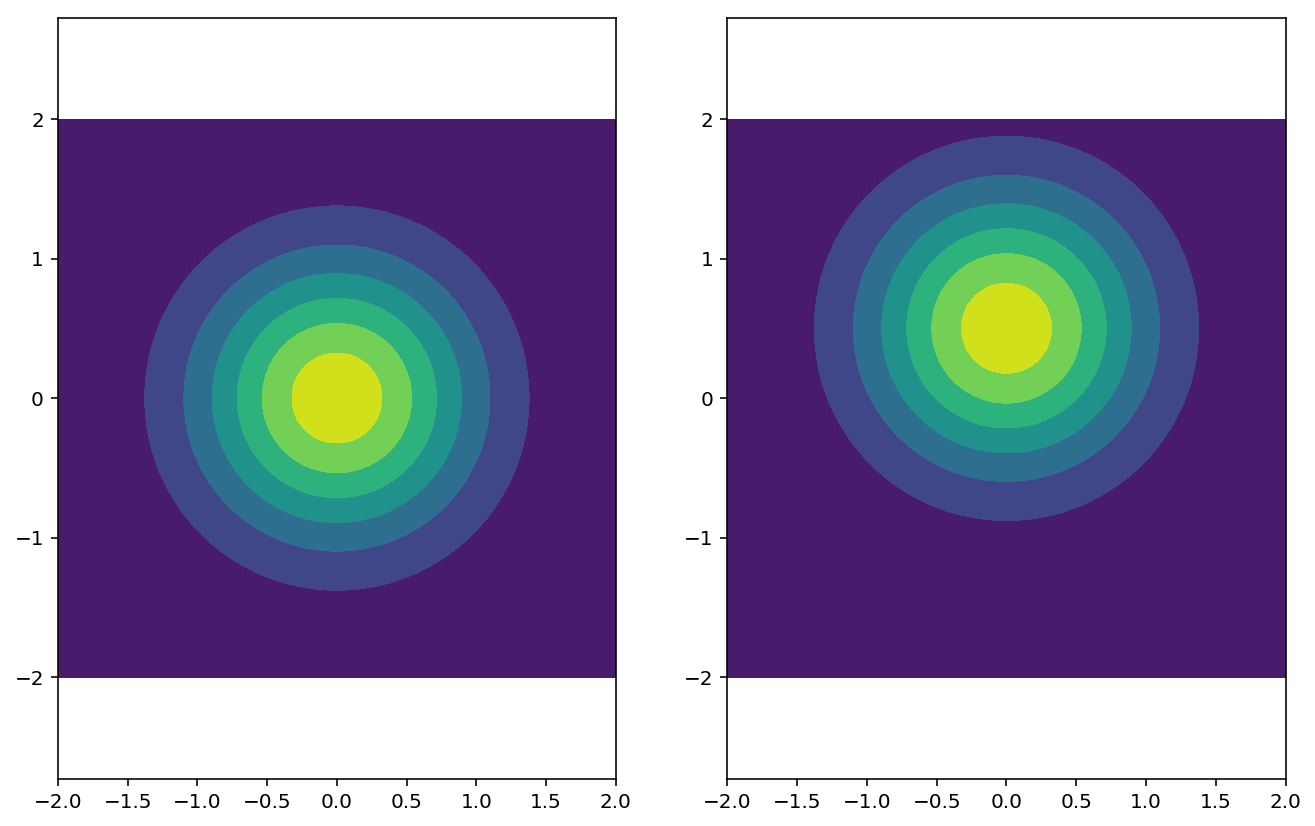

In [5]:
import numpy as np
n = 64
p = 3
alpha = 0.5*np.ones(n)
x, deltax = np.linspace(-2,2,n,retstep=True)
x, y = np.meshgrid(x,x)
df = np.exp(-(x*x+y*y))
df = np.asfortranarray(df)
fig  = plt.figure()
axes = fig.add_subplot(121)
axes.contourf(x,y,df);
axes.set_aspect('equal','datalim')
bsl_fftw.advection(p, deltax, alpha, df)
axes = fig.add_subplot(122)
axes.contourf(x,y,df);
axes.set_aspect('equal','datalim')

error: failed in converting 4th argument `df' of _fortran_magic_3304a8c3af8e688a8a08ba3f329ec3a2.bsl_fftw.advection to C/Fortran array